ログからデータを抽出しファイルに格納

extracted_eventsデータから時刻と通信可能ノードのリスト(receivable_time_id.json)を出す

In [23]:
import json

def make_receivable_time_id_file(log_folder_path):
	extracted_events_file_path = log_folder_path + "extracted_events.json"

	with open(extracted_events_file_path, 'r') as f:
		extracted_data = json.load(f)

	# 必要な情報を抽出して辞書にまとめる
	receivable_time_id_data = {}
	for key, value in extracted_data.items():
		receivable_time_id_data [value["startTime"]] = value["receivable_id_list"]
		
	# write to the json file
	with open( log_folder_path + 'receivable_time_id.json', 'w') as f:
		json.dump(receivable_time_id_data, f, indent=4)


# read the json file
speed = 70 # km/hour
booth_change = True
has_multi_proposer = True
proposer_list = [0,1,2]
validator_num = 250
validator_list = [i for i in range(validator_num  + len(proposer_list)) if i not in proposer_list]

if booth_change:
	if has_multi_proposer:
		for proposer_id in proposer_list:
			log_folder_path = "./results/speed" + str(speed) + "/250vehicle/" + str(proposer_id) + "/"
			make_receivable_time_id_file(log_folder_path)
	else:
		log_folder_path = "./results/speed" + str(speed) + "/250vehicle/"
		make_receivable_time_id_file(log_folder_path)
else:
	log_folder_path = "./results/speed" + str(speed) + "/"
	make_receivable_time_id_file(log_folder_path)



receivable_time_idデータから時刻の合間を補完したextended_time_id.jsonを作成

In [24]:
import json

def make_extended_time_id_file(log_folder_path):

	receivable_time_id_data_path = log_folder_path + 'receivable_time_id.json'
	with open(receivable_time_id_data_path, 'r') as f:
		receivable_time_id_data  = json.load(f)


	round_time_id_data = {}
	for key, value in receivable_time_id_data.items():
		round_time_id_data[str(f"{round(float(key), 2):.2f}")] = value


	# order the keys
	round_time_id_data = dict(sorted(round_time_id_data.items(), key=lambda x: float(x[0])))


	extended_time_id_data = {}
	# 元の辞書のキーと値をループして処理
	for key, value in round_time_id_data.items():
		# 新しいキーを追加
		extended_time_id_data[key] = value

		# 小数部を1ずつ増やしながら、指定された範囲のキーが欠けている場合に追加する
		for decimal in range(1,10):
			new_key = f"{round(float(key) + decimal * 0.01, 2):.2f}"
			# 小数点第三位で四捨五入
			if new_key not in round_time_id_data:  # 新しいキーが元の辞書に存在しない場合
				extended_time_id_data[new_key] = value  # 新しいキーを追加し、空のリストを値として設定
			else:
				break

	# write to the json file
	with open( log_folder_path + 'extended_time_id.json', 'w') as f:
		json.dump(extended_time_id_data, f, indent=4)


# read the json file
speed = 70 # km/hour
booth_change = True
has_multi_proposer = True
proposer_list = [0,1,2]
validator_num = 250
validator_list = [i for i in range(validator_num  + len(proposer_list)) if i not in proposer_list]

if booth_change:
	if has_multi_proposer:
		for proposer_id in proposer_list:
			log_folder_path = "./results/speed" + str(speed) + "/250vehicle/" + str(proposer_id) + "/"
			make_extended_time_id_file(log_folder_path)
	else:
		log_folder_path = "./results/speed" + str(speed) + "/250vehicle/"
		make_extended_time_id_file(log_folder_path)
else:
	log_folder_path = "./results/speed" + str(speed) + "/"
	make_extended_time_id_file(log_folder_path)

Vguardで用いるデータに整形(communication_data_for_vguard)

In [25]:
speed = 70 # km/hour
booth_change = True
has_multi_proposer = True
proposer_list = [0,1,2]
validator_num = 250
validator_list = [i for i in range(validator_num  + len(proposer_list)) if i not in proposer_list]
log_folder_path = "./results/speed" + str(speed) + "/250vehicle/"


all_communication_data = {}
for proposer_id in proposer_list:
    # communication-data.jsonを読み込む
    with open(log_folder_path + str(proposer_id) + '/extended_time_id.json', 'r') as file:
        proposer_communication_data = json.load(file)
    all_communication_data[proposer_id] = proposer_communication_data
    with open(log_folder_path + str(proposer_id) + '/communication_node_for_vguard_' + str(proposer_id) + '.json', 'w') as file:
        json.dump(all_communication_data[proposer_id], file, indent=4)


# validator_listに基づいてバリデータの通信可能なproposerリストを作成
validator_output_data = {validator: {} for validator in validator_list}

# まず最初に、最初のプロポーザのキーの集合を基準にする
common_keys = set(all_communication_data[proposer_list[0]].keys())

# proposer_listのすべてのiに対して共通するkeyを取得
for i in range(1, len(proposer_list)):
    # 各プロポーザのキーとの共通集合を更新
    common_keys &= set(all_communication_data[proposer_list[i]].keys())   

# common_keysの中身を数値に変換してソート
common_keys_as_floats = sorted([float(key) for key in common_keys])
common_keys_as_strings = [f"{key:.2f}" for key in common_keys_as_floats]


for key in common_keys_as_strings:
    for validator in validator_list:
        # 各バリデータに対して通信可能なプロポーザーリストを収集
        validator_communication_list = []
        for proposer_id in proposer_list:
            # プロポーザーのリストにバリデータが含まれているかをチェック
            if validator in all_communication_data[proposer_id][key]:
                validator_communication_list.append(proposer_id)
        
        # 通信可能なプロポーザーリストを順番通りに保存
        validator_output_data[validator][key] = validator_communication_list

# communication-data-2.json から communication-data-12.json にデータを保存
for validator_id in validator_list:
    filename = log_folder_path + str(validator_id) + '/communication_node_for_vguard_' + str(validator_id) + '.json'
    with open(filename, 'w') as file:
        json.dump(validator_output_data[validator_id], file, indent=4)


IMMUが作るブロックチェーンの参加者リストを作成

In [31]:
speed = 40 # km/hour
booth_change = True
has_multi_proposer = True
proposer_list = [0,1,2]
validator_num = 250
validator_list = [i for i in range(validator_num  + len(proposer_list)) if i not in proposer_list]
log_folder_path = "./results/speed" + str(speed) + "/250vehicle/"


all_communication_data = {}
for proposer_id in proposer_list:
    # communication-data.jsonを読み込む
    with open(log_folder_path + str(proposer_id) + '/extended_time_id.json', 'r') as file:
        proposer_communication_data = json.load(file)
    all_communication_data[proposer_id] = proposer_communication_data
    with open(log_folder_path + str(proposer_id) + '/immu_participant_node_' + str(proposer_id) + '.json', 'w') as file:
        json.dump(all_communication_data[proposer_id], file, indent=4)

抽出したイベントからグラフを作る

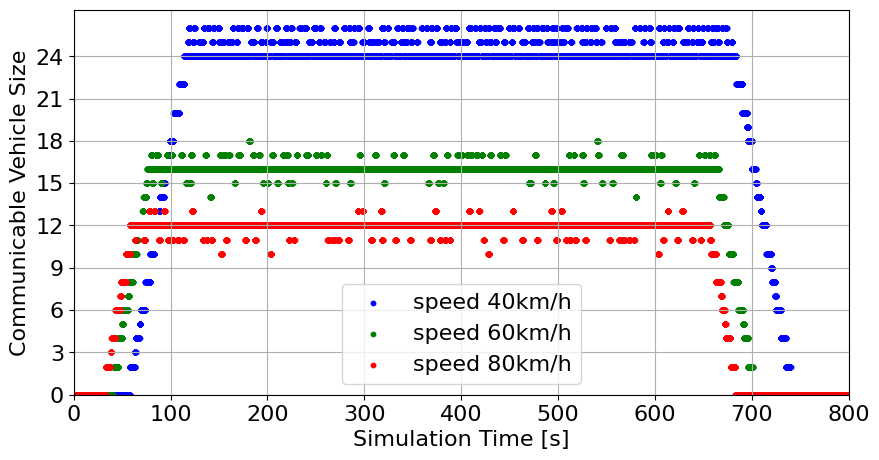

In [5]:
import matplotlib.pyplot as plt
import json
from collections import Counter


def count_nodes_for_plot(speed):

    log_folder_path = "./results/speed" + str(speed) + "/250vehicle/1/"
    extracted_events_file_path = log_folder_path + "/extracted_events.json"

    # extracted_events.json jsonデータを読み込む
    with open(extracted_events_file_path, 'r') as f:
        data = json.load(f)


    # グラフにプロットするデータを抽出
    time_series = []
    status_counts = []

    for event_id, event_info in data.items():
        start_time = float(event_info['startTime'])
        status_count = int(event_info["receivable_id_count"])
        time_series.append(start_time)
        status_counts.append(status_count)
    
    return time_series, status_counts


# speed = 40
time_series, status_counts = count_nodes_for_plot(40)

# speed = 60
time_series2, status_counts2 = count_nodes_for_plot(60)

# speed = 80
time_series3, status_counts3 = count_nodes_for_plot(80)

# 3つwo1つのgraphにまとめる
plt.figure(figsize=(10, 5))
plt.scatter(time_series, status_counts, c='blue', marker='o', s=10, label='speed 40km/h')
plt.scatter(time_series2, status_counts2, c='green', marker='o', s=10, label='speed 60km/h')
plt.scatter(time_series3, status_counts3, c='red', marker='o', s=10, label='speed 80km/h')
# plt.scatter(time_series, status_counts,facecolors='none', edgecolors='blue', marker='o', s=10, label='speed 40km/h')
# plt.scatter(time_series2, status_counts2, facecolors='none', edgecolors='green', marker='o', s=10, label='speed 60km/h')
# plt.scatter(time_series3, status_counts3, facecolors='none', edgecolors='red', marker='o', s=10, label='speed 80km/h')
plt.xlabel('Simulation Time [s]', fontsize=16)
plt.ylabel('Communicable Vehicle Size', fontsize=16)

plt.ylim(0, None)
plt.xlim(0, 800)

plt.xticks(fontsize=16)
plt.yticks(range(0, max(status_counts)+1, 3), fontsize=16)

plt.grid(True)
plt.legend(fontsize=16)
plt.show()



# # グラフを描画
# plt.figure(figsize=(10, 5))
# plt.scatter(time_series, status_counts, c='blue', marker='o', s=20)
# plt.xlabel('Time (seconds)', fontsize=12)
# plt.ylabel('Count of Possible Reception Nodes', fontsize=12)


# # plt.title('Possible Reception Nodes Over Time')
# # y軸の範囲を0以上に設定
# plt.ylim(0, None)
# # x軸の範囲も0以上に設定
# plt.xlim(0, 300)

# # y軸の目盛りを整数に設定
# plt.xticks(fontsize=12)
# plt.yticks(range(0, max(status_counts)+1, 1), fontsize=12)

# plt.grid(True)
# plt.show()




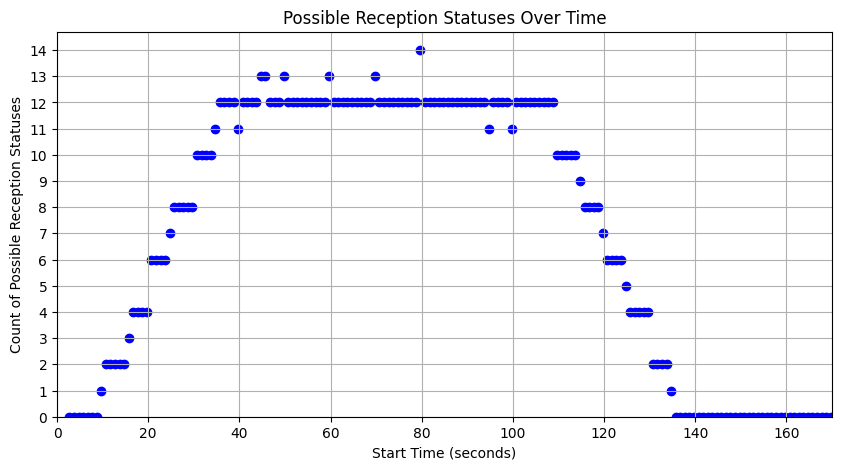


In [ ]:

import csv
import json
import matplotlib.pyplot as plt

def caluculate_booth_change_average_time(speed):

	artery_result_folder_path = "./results/speed" + str(speed) + "/"
	duration = 50

	# read the artery file
	artery_result_file_path = artery_result_folder_path + "extended_time_id.json"
	with open(artery_result_file_path, 'r') as f:
		artery_result = json.load(f)

	# 初めて車の台数が前の時間より少なくなる地点を実験の開始時点として設定する。
	experiment_start_time = None
	previous_length = 0
	for key, value in artery_result.items():
		if len(value) < previous_length:
			print("Key where the list length decreases for the first time:", key)
			experiment_start_time = round(float(key), 2)
			break
		previous_length = len(value)
	else:
		print("No decrease in list length found.")

	experiment_end_time = experiment_start_time + duration

	last_booth = artery_result[str(experiment_start_time)]
	now_booth = []
	change_time = [experiment_start_time]
	now_time = experiment_start_time + 0.01
	while now_time <= experiment_end_time:
		now_time = round(now_time, 2)
		now_booth = artery_result[str(now_time)]
		if now_booth != last_booth:
			change_time.append(now_time)
			last_booth = now_booth
		now_time += 0.01
	
	print("Change time:", change_time)

	# caluculate the average time between booth changes
	change_duration_time = []
	average_time = 0
	for i in range(1, len(change_time)):
		average_time += change_time[i] - change_time[i-1]
		change_duration_time.append(change_time[i] - change_time[i-1])
	average_time /= len(change_time) - 1

	print("Average time between booth changes:", average_time)

	# make a graph
	plt.figure(figsize=(10, 5))
	plt.plot(range(1, len(change_time)), change_duration_time, marker='o')
	plt.xlabel('Change Number')
	plt.ylabel('Time Between Booth Changes (seconds)')
	plt.title('Time Between Booth Changes Over Change Number')
	plt.grid(True)
	plt.show()

	change_time 

	return average_time




speed_list = [40, 50, 60, 70, 80]
average_time_list = []
for speed in speed_list:
	average_time_list.append(caluculate_booth_change_average_time(speed))

# make a graph
plt.figure(figsize=(10, 5))
plt.plot(speed_list, average_time_list, marker='o')
# make x alis label bigger
plt.xlabel('Speed (km/h)', fontsize=16)
plt.ylabel('Average Time of Booth Changes (s)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('Average Time Between Booth Changes Over Speed')

# y軸の範囲を0以上に設定
plt.ylim(0, 3)
plt.grid(True)
plt.show()


	


success rate

Key where the list length decreases for the first time: 72.06
Most common booth size: 24
Speed: 40
Most common booth size: 310
All block count: 4996
Success block rate 0.03362690152121697
Success count rate 0.053691275167785234

Key where the list length decreases for the first time: 58.02
Most common booth size: 20
Speed: 50
Most common booth size: 310
All block count: 5000
Success block rate 0.0852
Success count rate 0.08588957055214724

Key where the list length decreases for the first time: 56.04
Most common booth size: 16
Speed: 60
Most common booth size: 310
All block count: 4999
Success block rate 0.484496899379876
Success count rate 0.5620915032679739

Key where the list length decreases for the first time: 50.04
Most common booth size: 14
Speed: 70
Most common booth size: 310
All block count: 4978
Success block rate 0.35636801928485334
Success count rate 0.41353383458646614

Key where the list length decreases for the first time: 39.06
Most common booth size: 12
Speed: 80
Most

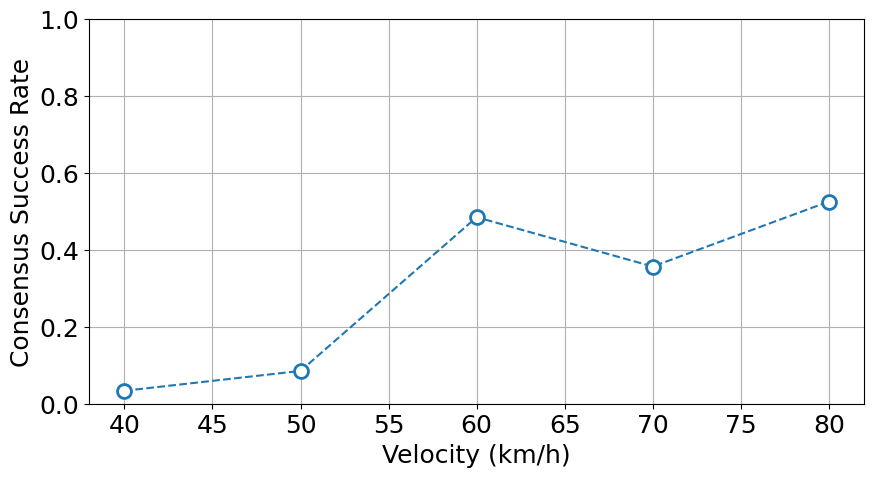

In [1]:

import csv
import json
import matplotlib.pyplot as plt


# booth_size = 4


def caluculate_success_rate(speed):
    message_size = 32
    network_delay = 10
    # static booth size
    # artery_result_folder_path = "./results/speed" + str(speed) + "/"

    # change booth size
    artery_result_folder_path = "./results/speed" + str(speed) + "/300vehicle/"

    # read the artery file
    artery_result_file_path = artery_result_folder_path + "extended_time_id.json"
    with open(artery_result_file_path, 'r') as f:
        artery_result = json.load(f)

    # 初めて車の台数が前の時間より少なくなる地点を実験の開始時点として設定する。
    experiment_start_time = None
    previous_length = 0
    for key, value in artery_result.items():
        if len(value) < previous_length:
            print("Key where the list length decreases for the first time:", key)
            experiment_start_time = round(float(key), 2)
            break
        previous_length = len(value)
    else:
        print("No decrease in list length found.")
    experiment_start_time = 100.0


    
    # define booth_size
    booth_size_dict = {}
    experiment_duration = 100 # karioki
    for key, value in artery_result.items():
        if float(key) >= experiment_start_time and float(key) <= experiment_start_time + experiment_duration:
            if len(value) not in booth_size_dict:
                booth_size_dict[len(value)] = 1
            booth_size_dict[len(value)] += 1

    # extract the most common booth size
    booth_size = max(booth_size_dict, key=booth_size_dict.get)
    print("Most common booth size:", booth_size)
    booth_size = 310


    # read the vguard file
    # vguard_result_folder_path = "../../../vguardbft/results/n" + str(booth_size) + "/boo" + str(booth_size) + "/m" + str(message_size) + "/d" + str(network_delay)  + "/"
    vguard_result_folder_path = "../../../vguardbft/results/booth_change/vs" + str(speed) + "/n" + str(booth_size) + "/m" + str(message_size) + "/d" + str(network_delay)  + "/"
    vguard_result_file_path = vguard_result_folder_path + "consensus_event_diff.csv"

    # load the csv file
    with open(vguard_result_file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # skip the header
        vguard_data = list(reader)



    # create a dictionary to store the experiment results
    experiment_result_dict = {}

    for vguard_event in vguard_data:
        vguard_event_start_time = round(experiment_start_time + float(vguard_event[1]), 2)
        vguard_event_end_time = round(experiment_start_time + float(vguard_event[2]), 2)
        # print(vguard_event_start_time, vguard_event_end_time)
        # vguard_event_end_time = round(experiment_start_time + float(vguard_event[1]) + (float(vguard_event[2]) - float(vguard_event[1]))/4, 2)
        # print(vguard_event_start_time, vguard_event_end_time)
        vguard_event_start_booth = artery_result[format(vguard_event_start_time, ".2f")]
        vguard_event_end_booth = artery_result[format(vguard_event_end_time, ".2f")]

        # check if the start and end booths are the same
        if vguard_event_start_booth == vguard_event_end_booth:
            is_success = True
        else:
            is_success = False
        
        experiment_result_dict[vguard_event[0]] = {
            "start_time": vguard_event_start_time,
            "end_time": vguard_event_end_time,
            "is_success": is_success,
            "block_num" : int(vguard_event[4])
        }



    # count the number of successful and failed events
    success_block = 0
    failed_block = 0
    success_count = 0
    failed_count = 0
    for event_id, event_info in experiment_result_dict.items():
        if event_info["is_success"]:
            success_block += event_info["block_num"]
            success_count += 1
        else:
            failed_block += event_info["block_num"]
            failed_count += 1

    success_block_rate = success_block / (success_block + failed_block)
    success_count_rate = success_count / (success_count + failed_count)

    # print result
    print("Speed:", speed)
    print("Most common booth size:", booth_size)
    print("All block count:", success_block + failed_block)
    print("Success block rate", success_block_rate)
    print("Success count rate", success_count_rate)
    print("")



    return success_block_rate, success_count_rate



speed = [40, 50, 60, 70, 80] # km/hour
success_block_rate_list = []
success_count_rate_list = []
for s in speed:
    success_block_rate, success_count_rate = caluculate_success_rate(s)
    success_block_rate_list.append(success_block_rate)
    success_count_rate_list.append(success_count_rate)


# # make a graph
# plt.figure(figsize=(10, 5))
# plt.plot(speed, success_block_rate_list, marker='o', label='Success Block Rate')
# # plt.plot(speed, success_count_rate_list, marker='o', label='Success Count Rate')
# plt.xlabel('Speed (km/h)', fontsize=18)
# plt.ylabel('Consensus Success Rate', fontsize=18)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# # plt.title('Success Rate vs Speed')
# # y軸の範囲を0以上1ikaに設定
# plt.ylim(0, 1)
# plt.grid(True)
# plt.show()

# グラフ作成
plt.figure(figsize=(10, 5))
plt.plot(speed, success_block_rate_list, marker='o', markersize=10, markerfacecolor='white', markeredgewidth=2, linestyle='--', label='Success Block Rate')
# plt.plot(speed, success_count_rate_list, marker='o', label='Success Count Rate')
plt.xlabel('Velocity (km/h)', fontsize=18)
plt.ylabel('Consensus Success Rate', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.title('Success Rate vs Speed')
# y軸の範囲を0.6以上1.0以下に設定
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.show()

